In [4]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marchioapriadi","key":"661a3e830a3a268a8e2028ea59be140c"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 99% 577M/586M [00:04<00:00, 204MB/s]
100% 586M/586M [00:04<00:00, 128MB/s]


In [7]:
import zipfile
import os

with zipfile.ZipFile('animals10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/datasetanimalcv1')


In [13]:
# Create a dataframe
src_dir = '/content/datasetanimalcv1/raw-img'

data = []
for class_name in os.listdir(src_dir):
    class_dir = os.path.join(src_dir, class_name)
    for img_name in os.listdir(class_dir):
        data.append([os.path.join(class_dir, img_name), class_name])

df = pd.DataFrame(data, columns=['path', 'class'])

<Axes: xlabel='class', ylabel='count'>

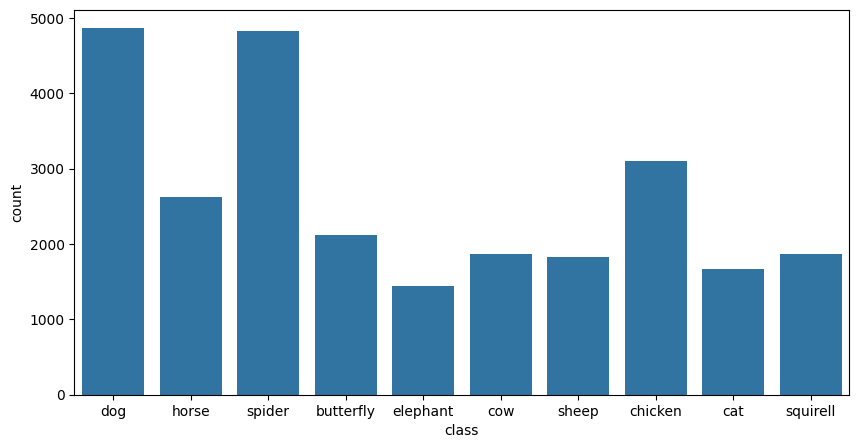

In [33]:
# See an image distribution per class
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='class')

In [34]:
# Split into 3 datasets
TRAIN_DF, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
VAL_DF, TEST_DF = train_test_split(temp_df, test_size=0.2, stratify=temp_df['class'], random_state=42)

In [35]:
# Applying augmentation only to a training generator
def create_generator(dataframe, training):
    idg = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ) if training else ImageDataGenerator(rescale=1.0 / 255)

    generator = idg.flow_from_dataframe(
        dataframe,
        x_col='path',
        y_col='class',
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=True if training else False
    )

    return generator

In [36]:
# Create all 3 generators
train_gen = create_generator(TRAIN_DF, True)
val_gen = create_generator(VAL_DF, False)
test_gen = create_generator(TEST_DF, False)

Found 18325 validated image filenames belonging to 10 classes.
Found 6283 validated image filenames belonging to 10 classes.
Found 1571 validated image filenames belonging to 10 classes.


In [37]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all VGG16 layers
for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(train_gen, epochs=10, validation_data=val_gen, verbose=1)

Epoch 1/10
573/573 [==============================] - 270s 470ms/step - loss: 1.0759 - accuracy: 0.6606 - val_loss: 0.6069 - val_accuracy: 0.7960
Epoch 2/10
573/573 [==============================] - 272s 474ms/step - loss: 0.7294 - accuracy: 0.7537 - val_loss: 0.5371 - val_accuracy: 0.8224
Epoch 3/10
573/573 [==============================] - 268s 467ms/step - loss: 0.6532 - accuracy: 0.7794 - val_loss: 0.4785 - val_accuracy: 0.8391
Epoch 4/10
573/573 [==============================] - 268s 468ms/step - loss: 0.6187 - accuracy: 0.7911 - val_loss: 0.4864 - val_accuracy: 0.8383
Epoch 5/10
573/573 [==============================] - 266s 465ms/step - loss: 0.5955 - accuracy: 0.8000 - val_loss: 0.4819 - val_accuracy: 0.8383
Epoch 6/10
573/573 [==============================] - 270s 471ms/step - loss: 0.5659 - accuracy: 0.8106 - val_loss: 0.4526 - val_accuracy: 0.8496
Epoch 7/10
573/573 [==============================] - 267s 465ms/step - loss: 0.5625 - accuracy: 0.8154 - val_loss: 0.4306 -

50/50 [==============================] - 6s 122ms/step


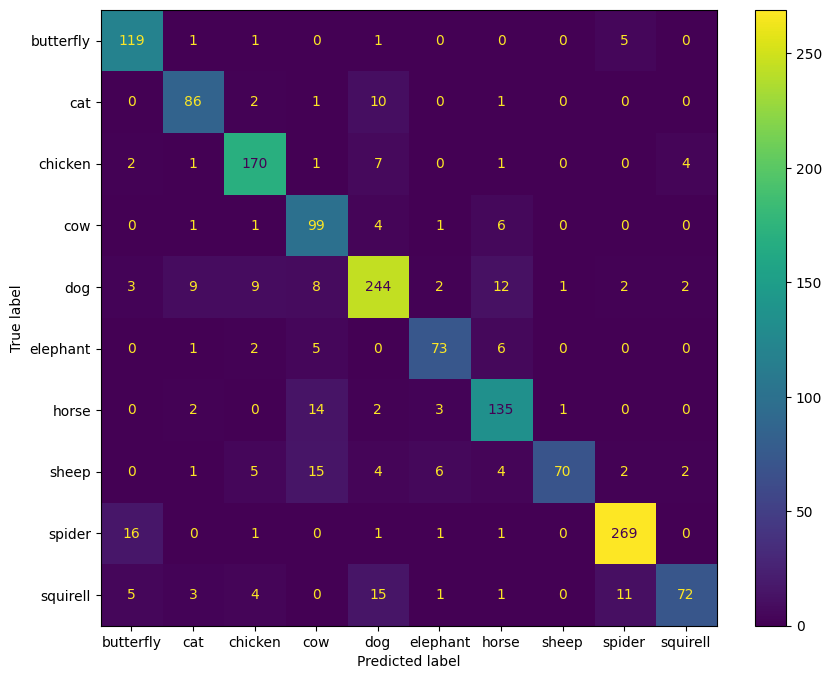

In [40]:
# Generate predictions for the test set
y_pred = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1)
y_hat = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# True class labels
y_true = test_gen.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_hat)

class_names = list(test_gen.class_indices.keys())

fig, ax = plt.subplots(figsize=(10,8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(ax=ax)

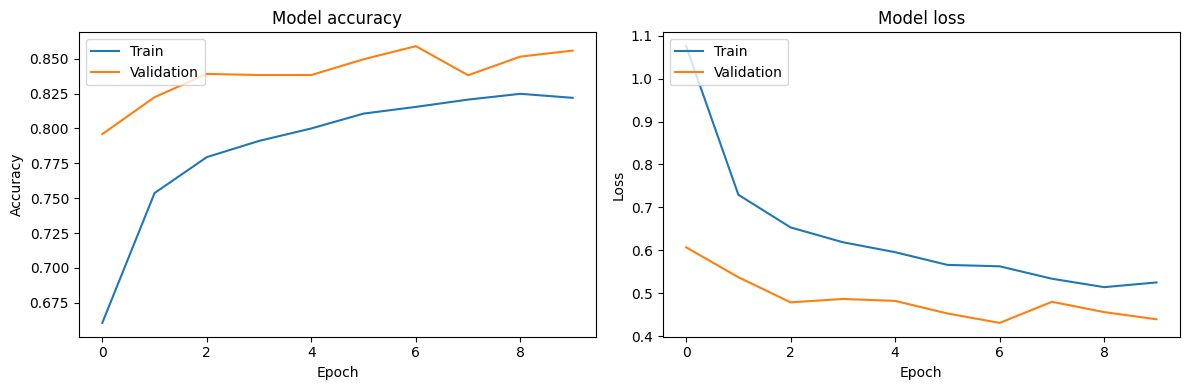

In [39]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
[[4.7618807e-09 3.3287456e-08 2.0169274e-08 7.5273977e-07 1.3484802e-05
  9.9998200e-01 1.6268033e-06 1.6009438e-06 3.1971994e-10 3.9575755e-07]]


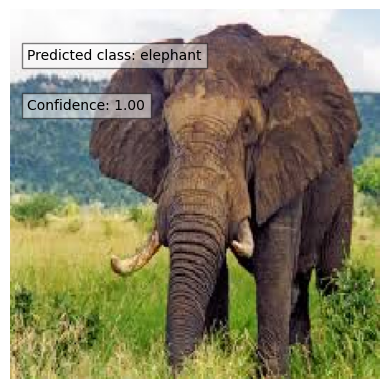

In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Memuat gambar untuk prediksi
img_path = 'C:/KUYLiah/Semester 8/Computer Vision/project/animalcv2/gajah.jpg'
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
img_array = img_array / 255.0  

# Melakukan prediksi
predictions = model.predict(img_array)

# Menampilkan hasil prediksi
print(predictions)

class_labels = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirell']

# Mendapatkan nilai confidence tertinggi dan indeks kelas prediksi
confidence = np.max(predictions)
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]

# Menampilkan gambar
plt.imshow(img)
plt.axis('off')

# Menambahkan teks prediksi dan confidence
plt.text(10, 30, f"Predicted class: {predicted_class}", bbox=dict(facecolor='white', alpha=0.5))
plt.text(10, 60, f"Confidence: {confidence:.2f}", bbox=dict(facecolor='white', alpha=0.5))

plt.show()

# predicted_class = class_labels[np.argmax(predictions)]
# print(f"Predicted class: {predicted_class}")

In [42]:
model.save('animalclasscv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
model = load_model('C:/KUYLiah/Semester 8/Computer Vision/project/animalcv2/animalclasscv2.h5')